# Clustering Algorithms: k-means and DBSCAN

## k-means

* Let’s train a k-means clusterer on this dataset. It will try to find each blob’s center and assign each instance to the closest blob:

In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array(
    [
        [ 0.2,  2.3],
        [-1.5 ,  2.3],
        [-2.8,  1.8],
        [-2.8,  2.8],
        [-2.8,  1.3]
    ]
)

blob_std = np.array(
    [
        0.4,
        0.3,
        0.1,
        0.1,
        0.1
    ]
)

X, y = make_blobs(
    n_samples=2000,
    centers=blob_centers,
    cluster_std=blob_std,
    random_state=7
)

k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

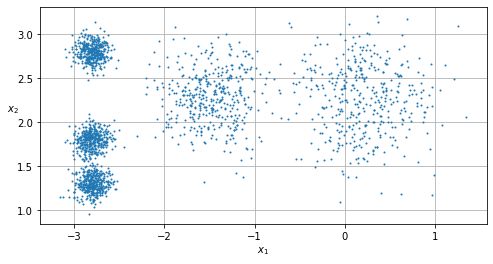

In [2]:
import matplotlib.pyplot as plt

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()


In [3]:
y_pred

array([0, 0, 4, ..., 3, 1, 0])

In [4]:
y_pred is kmeans.labels_

True

* For centroids:

In [5]:
kmeans.cluster_centers_

array([[-2.80214068,  1.55162671],
       [ 0.08703534,  2.58438091],
       [-1.46869323,  2.28214236],
       [-2.79290307,  2.79641063],
       [ 0.31332823,  1.96822352]])

In [6]:
X_new = np.array(
    [
        [0, 2],
        [3, 2],
        [-3, 3],
        [-3, 2.5]
    ]
    
)

kmeans.predict(X_new)

array([4, 4, 3, 3])

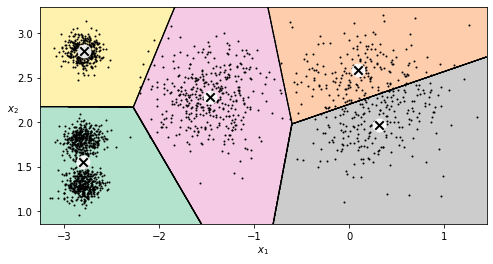

In [7]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

* In the KMeans class, the transform() method measures the distance from each instance to every centroid:

In [8]:
kmeans.transform(X_new).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

## Centroid initialization methods

* If you happen to know approximately where the centroids should be (e.g., if you ran another clustering algorithm earlier), then you can set the init hyperparameter to a NumPy array containing the list of centroids, and set n_init to 1:

In [9]:
good_init = np.array(
    [
        [-3, 3],
        [-3, 2],
        [-3, 1],
        [-1, 2],
        [0, 2]
    ]
)

kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)

kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

* The number of random initializations is controlled by the n_init hyperparameter: by default it is equal to 10, which means that the whole algorithm described earlier runs 10 times when you call fit(), and Scikit-Learn keeps the best solution. But how exactly does it know which solution is the best? It uses a performance metric! That metric is called the model’s ``inertia``, which is the sum of the squared distances between the instances and their closest centroids.

In [10]:
kmeans.inertia_

211.5985372581684

In [11]:
kmeans.score(X)

-211.59853725816836

* The score() method returns the negative inertia (it’s negative because a predictor’s score() method must always respect Scikit-Learn’s “greater is better” rule: if a predictor is better than another, its score() method should return a greater score)

## Accelerated k-means and mini-batch k-means

* Instead of using the full dataset at each iteration, the algorithm is capable of using mini-batches, moving the centroids just slightly at each iteration. This speeds up the algorithm (typically by a factor of three to four) and makes it possible to cluster huge datasets that do not fit in memory. Scikit-Learn implements this algorithm in the MiniBatchKMeans class, which you can use just like the KMeans class:

In [12]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)

minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

100/100

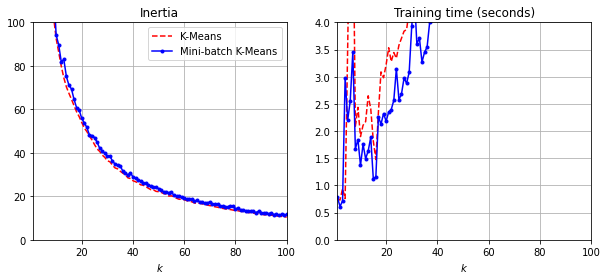

In [13]:
# extra code – this cell generates and saves Figure 9–6

from timeit import timeit

max_k = 100
times = np.empty((max_k, 2))
inertias = np.empty((max_k, 2))
for k in range(1, max_k + 1):
    kmeans_ = KMeans(n_clusters=k, algorithm="lloyd", n_init=10, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)
    print(f"\r{k}/{max_k}", end="")  # \r returns to the start of line
    times[k - 1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("minibatch_kmeans.fit(X)", number=10,
                             globals=globals())
    inertias[k - 1, 0] = kmeans_.inertia_
    inertias[k - 1, 1] = minibatch_kmeans.inertia_

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, max_k + 1), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Inertia")
plt.legend()
plt.axis([1, max_k, 0, 100])
plt.grid()

plt.subplot(122)
plt.plot(range(1, max_k + 1), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Training time (seconds)")
plt.axis([1, max_k, 0, 4])
plt.grid()

## Finding the optimal number of clusters

In [14]:
kmeans_k3 = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_k3.fit(X)
kmeans_k8 = KMeans(n_clusters=8, n_init=10, random_state=42)
kmeans_k8.fit(X)

KMeans(n_init=10, random_state=42)

In [15]:
kmeans_k3.inertia_

653.216719002155

In [16]:
kmeans_k8.inertia_

119.22484592677111

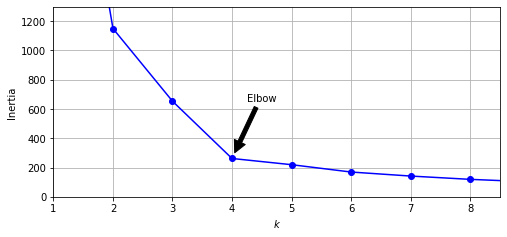

In [17]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()

* Another approach is to look at the ``silhouette score``

In [18]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

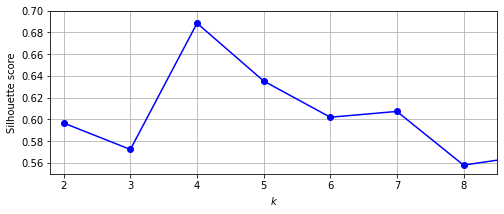

In [19]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()

## Using Clustering for Image Segmentation

In [20]:
#import PIL

#image = np.asarray(PIL.Image.open(filepath))
#image.shape

In [21]:
#X = image.reshape(-1, 3)
#kmeans = KMeans(n_clusters=8, n_init=10, random_state=42).fit(X)
#segmented_img = kmeans.cluster_centers_[kmeans.labels_]
#segmented_img = segmented_img.reshape(image.shape)

## Using Clustering for Semi-Supervised Learning

* Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances. In this section, we’ll use the digits dataset, which is a simple MNIST-like dataset containing 1,797 grayscale 8 × 8 images representing the digits 0 to 9. First, let’s load and split the dataset

In [22]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

* We will pretend we only have labels for 50 instances. To get a baseline performance, let’s train a logistic regression model on these 50 labeled instances:

In [23]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50 #Meanwhile we're really pretending :)

log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

* We can then measure the accuracy of this model on the test set (note that the test set must be labeled):

In [24]:
log_reg.score(X_test, y_test)

0.7581863979848866

* The model’s accuracy is just 74.8%. That’s not great: indeed, if you try training the model on the full training set, you will find that it will reach about 90.7% accuracy. Let’s see how we can do better. First, let’s cluster the training set into 50 clusters. Then, for each cluster, we’ll find the image closest to the centroid. We’ll call these images the representative images:

In [25]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)

kmeans.fit(X_train)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

* the 50 representative images:

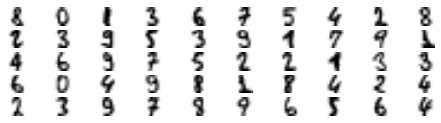

In [26]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

* Let’s look at each image and manually label them:

In [27]:
y_representative_digits = np.array([
    8, 0, 1, 3, 6, 7, 5, 4, 2, 8,
    2, 3, 9, 5, 3, 9, 1, 7, 9, 1,
    4, 6, 9, 7, 5, 2, 2, 1, 3, 3,
    6, 0, 4, 9, 8, 1, 8, 4, 2, 4,
    2, 3, 9, 7, 8, 9, 6, 5, 6, 4
])

* Now we have a dataset with just 50 labeled instances, but instead of being random instances, each of them is a representative image of its cluster. Let’s see if the performance is any better:

In [28]:
log_reg = LogisticRegression(max_iter=10_000)

log_reg.fit(X_representative_digits, y_representative_digits)

log_reg.score(X_test, y_test)

0.8337531486146096

* we can go one step further: what if we propagated the labels to all the other instances in the same cluster? This is called label propagation:

In [29]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)

for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [30]:
y_train_propagated

array([0, 1, 2, ..., 4, 4, 7], dtype=int64)

# Gaussian Mixtures

In [31]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [32]:
gm.weights_

array([0.20032189, 0.59989596, 0.19978216])

In [33]:
gm.means_

array([[ 0.19937187,  2.25813691],
       [-2.80278963,  1.96665812],
       [-1.48543693,  2.28573643]])

In [34]:
gm.covariances_

array([[[ 1.46166449e-01, -4.84946828e-03],
        [-4.84946828e-03,  1.56280672e-01]],

       [[ 9.95376970e-03,  7.16529541e-04],
        [ 7.16529541e-04,  3.96947649e-01]],

       [[ 8.79984367e-02,  1.46541758e-04],
        [ 1.46541758e-04,  9.01630979e-02]]])

In [35]:
gm.converged_

True

In [36]:
gm.n_iter_

3

In [37]:
gm.predict(X)

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [38]:
gm.predict_proba(X).round(3)

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [39]:
# A Gaussian mixture model is a generative model, meaning you can sample new instances from it

X_new, y_new = gm.sample(6)

In [40]:
X_new

array([[-2.75712919,  1.76654019],
       [-2.81407201,  2.67342712],
       [-1.61535318,  2.44100119],
       [-1.22876105,  2.51633913],
       [-1.62077865,  2.38986685],
       [-1.62864737,  2.51673815]])

In [41]:
y_new

array([1, 1, 2, 2, 2, 2])

In [42]:
# It is also possible to estimate the density of the model at any given location

gm.score_samples(X).round(2)

array([-0.63,  0.13, -7.15, ..., -0.32, -1.63, -0.95])

## Using Gaussian Mixtures for Anomaly Detection

In [ ]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

anomalies[:10]

array([[ 0.96077126,  1.17046777],
       [ 0.80986725,  1.54946936],
       [-1.12516913,  1.37698374],
       [ 1.10397879,  2.64761573],
       [-3.12601755,  1.14738531],
       [ 1.34442688,  2.05596398],
       [-3.09078122,  2.73894736],
       [ 0.98260815,  1.40014751],
       [-2.17001425,  2.65826737],
       [-2.44999309,  1.72259708]])

* Just like k-means, the GaussianMixture algorithm requires you to specify the number of clusters. So how can you find that number?

## Selecting the Number of Clusters

* To compute the BIC and AIC, call the bic() and aic() methods:

In [45]:
gm.bic(X)

5168.669155929095

In [46]:
gm.aic(X)

5073.45381411688

## Bayesian Gaussian Mixture Models

* Rather than manually searching for the optimal number of clusters, you can use the BayesianGaussianMixture class, which is capable of giving weights equal (or close) to zero to unnecessary clusters.

In [47]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
bgm.weights_.round(2)

array([0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ])

# Exercises

#### 10

* The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. Forty different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the sklearn.datasets.fetch_olivetti_faces() function, then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you will probably want to use stratified sampling to ensure that there are the same number of images per person in each set. Next, cluster the images using k-means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter). Visualize the clusters: do you see similar faces in each cluster?

In [49]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\MRE\scikit_learn_data


In [50]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

In [51]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [52]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data,
                                                   olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [53]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


* To speed things up, we'll reduce the data's dimensionality using PCA:

In [54]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

In [55]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print(f"k={k}")
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


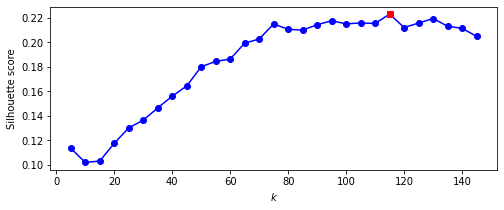

In [56]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.plot(best_k, best_score, "rs")

In [57]:
best_k

115

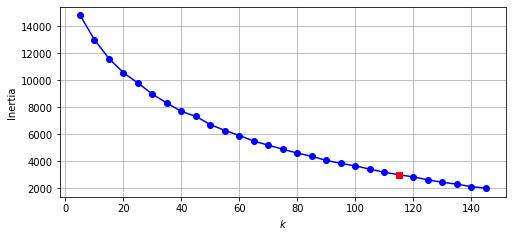

In [58]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.plot(best_k, best_inertia, "rs")
plt.grid()

In [59]:
best_model = kmeans_per_k[best_index]

Cluster 0


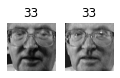

Cluster 1


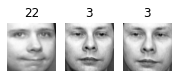

Cluster 2


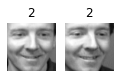

Cluster 3


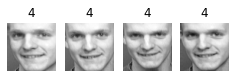

Cluster 4


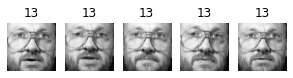

Cluster 5


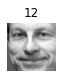

Cluster 6


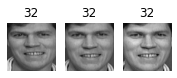

Cluster 7


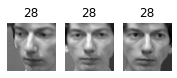

Cluster 8


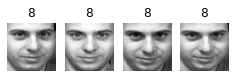

Cluster 9


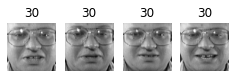

Cluster 10


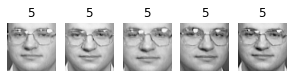

Cluster 11


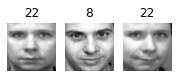

Cluster 12


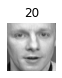

Cluster 13


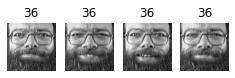

Cluster 14


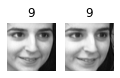

Cluster 15


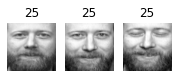

Cluster 16


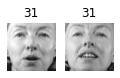

Cluster 17


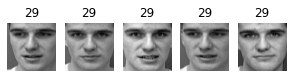

Cluster 18


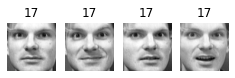

Cluster 19


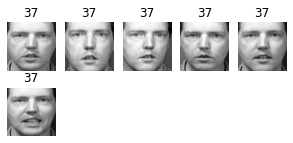

Cluster 20


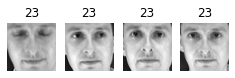

Cluster 21


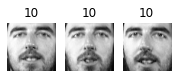

Cluster 22


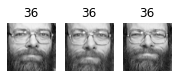

Cluster 23


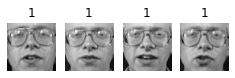

Cluster 24


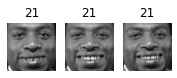

Cluster 25


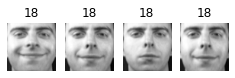

Cluster 26


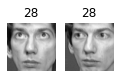

Cluster 27


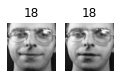

Cluster 28


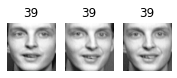

Cluster 29


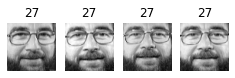

Cluster 30


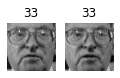

Cluster 31


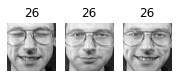

Cluster 32


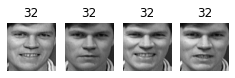

Cluster 33


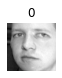

Cluster 34


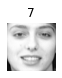

Cluster 35


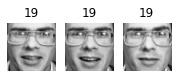

Cluster 36


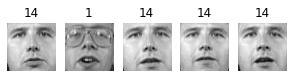

Cluster 37


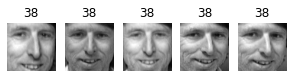

Cluster 38


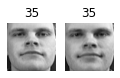

Cluster 39


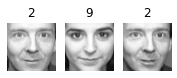

Cluster 40


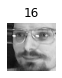

Cluster 41


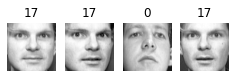

Cluster 42


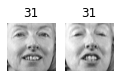

Cluster 43


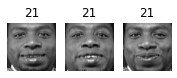

Cluster 44


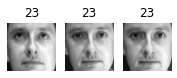

Cluster 45


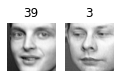

Cluster 46


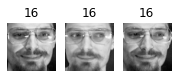

Cluster 47


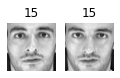

Cluster 48


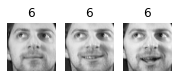

Cluster 49


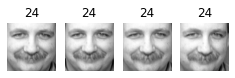

Cluster 50


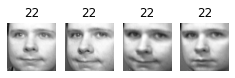

Cluster 51


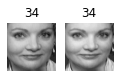

Cluster 52


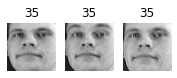

Cluster 53


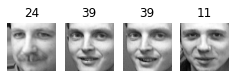

Cluster 54


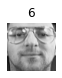

Cluster 55


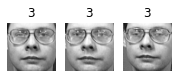

Cluster 56


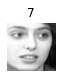

Cluster 57


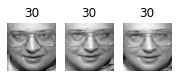

Cluster 58


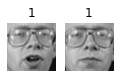

Cluster 59


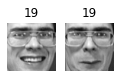

Cluster 60


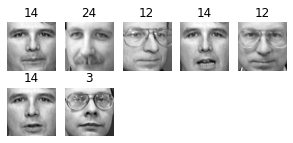

Cluster 61


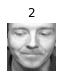

Cluster 62


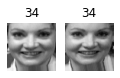

Cluster 63


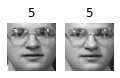

Cluster 64


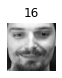

Cluster 65


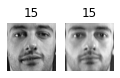

Cluster 66


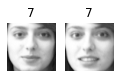

Cluster 67


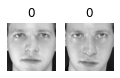

Cluster 68


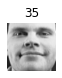

Cluster 69


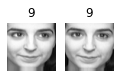

Cluster 70


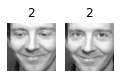

Cluster 71


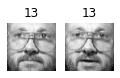

Cluster 72


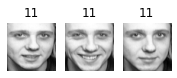

Cluster 73


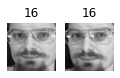

Cluster 74


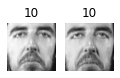

Cluster 75


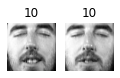

Cluster 76


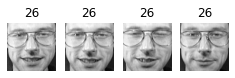

Cluster 77


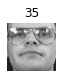

Cluster 78


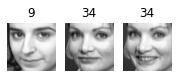

Cluster 79


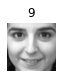

Cluster 80


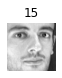

Cluster 81


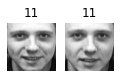

Cluster 82


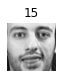

Cluster 83


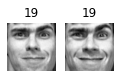

Cluster 84


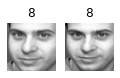

Cluster 85


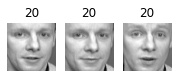

Cluster 86


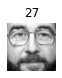

Cluster 87


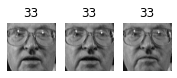

Cluster 88


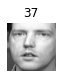

Cluster 89


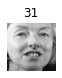

Cluster 90


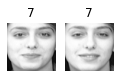

Cluster 91


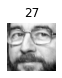

Cluster 92


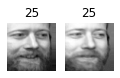

Cluster 93


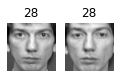

Cluster 94


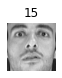

Cluster 95


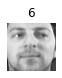

Cluster 96


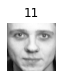

Cluster 97


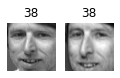

Cluster 98


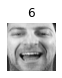

Cluster 99


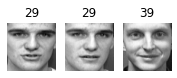

Cluster 100


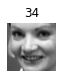

Cluster 101


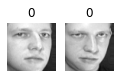

Cluster 102


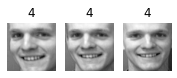

Cluster 103


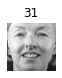

Cluster 104


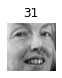

Cluster 105


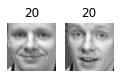

Cluster 106


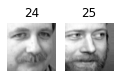

Cluster 107


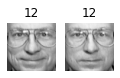

Cluster 108


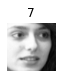

Cluster 109


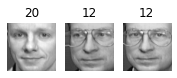

Cluster 110


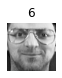

Cluster 111


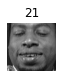

Cluster 112


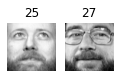

Cluster 113


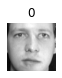

Cluster 114


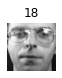

In [60]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)